In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

from statsmodels.graphics import tsaplots
from statsmodels.tsa import arima_process
import pmdarima as pm

import util

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (15, 6)  # overwrite the default figure size
plt.rcParams['axes.grid'] = True          # add the grid lines by default 

# Importing data 

In [4]:
root = Path().absolute().parent
fp = root / 'data' / 'week2' / 'sealevel.csv'
df = pd.read_csv(fp, parse_dates=[['year', 'month']], index_col=0)

df.head(3)

,sealevel
year_month,
1995-01-01,0.0
1995-02-01,2.1
1995-03-01,1.8


# Exploration

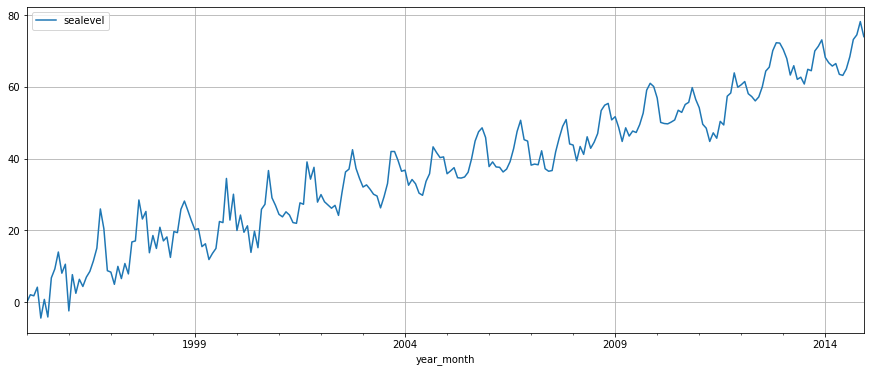

In [5]:
df.plot()

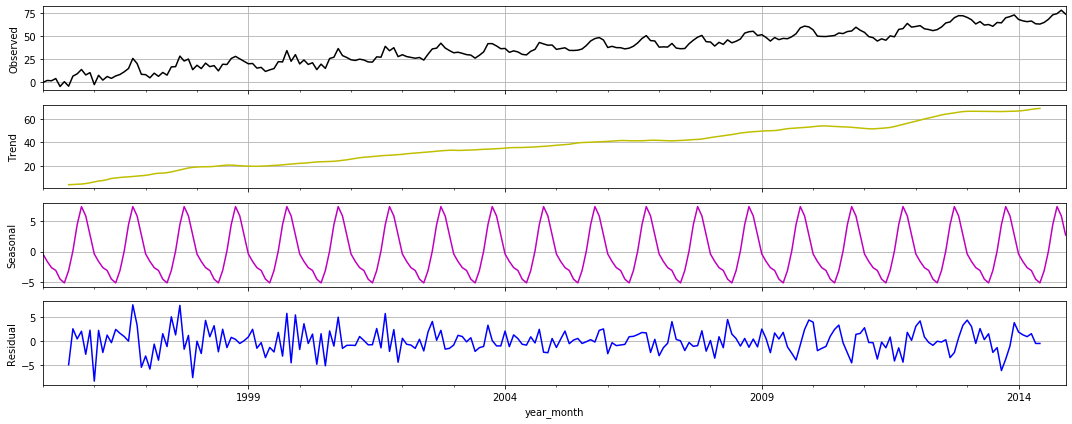

In [6]:
util.plot_colored_seasonal_decompose(df, freq=12);

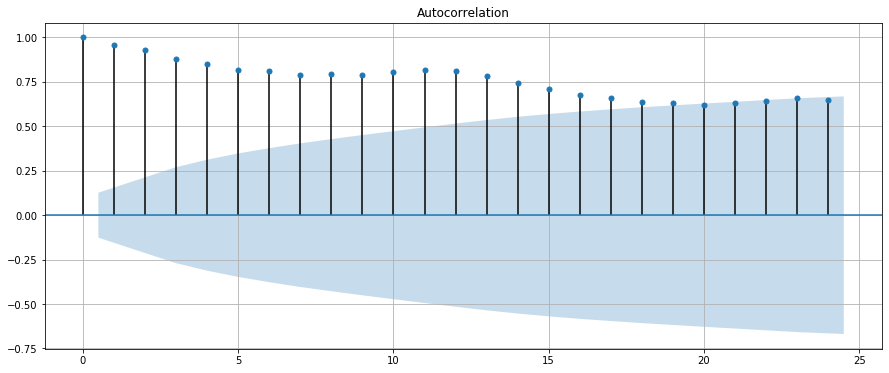

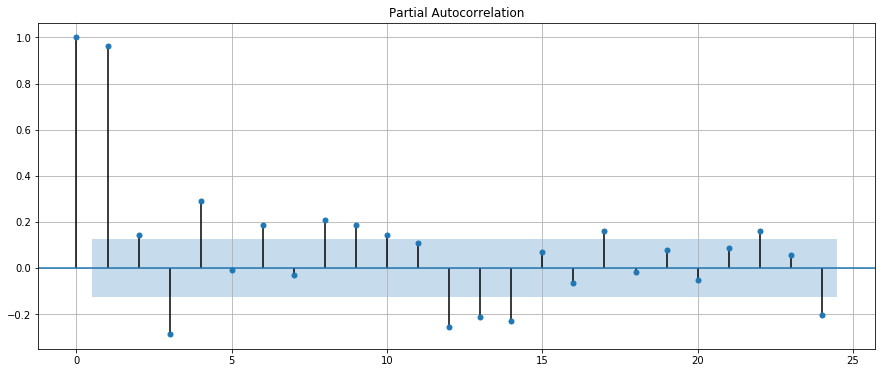

In [7]:
tsaplots.plot_acf(df)
tsaplots.plot_pacf(df);

# Model generation

In [8]:
values = df.sealevel.values

In [10]:
t = util.timeindex_to_yearfraction(df.index)

exog = pd.DataFrame({
    't': t,
    'sin': np.sin(2*np.pi*t),
    'cos': np.cos(2*np.pi*t)
})

exog.head(3)

,t,sin,cos
0,0.000000,0.000000,1.000000
1,0.084873,0.508356,0.861147
2,0.161533,0.849450,0.527668


In [11]:
models = pm.auto_arima(
    values,  
    seasonal=False,   
    exogenous=exog.values,
    
    d=0,
    max_p=5, max_q=3,
    trace=True,  # print models that are being tried
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
    return_valid_fits=True,  # to return all valid models, so we can select the ARMA(2,2)
)

Fit ARIMA: order=(2, 0, 2); AIC=1195.395, BIC=1226.721, Fit time=0.427 seconds
Fit ARIMA: order=(0, 0, 0); AIC=1310.772, BIC=1328.175, Fit time=0.023 seconds
Fit ARIMA: order=(1, 0, 0); AIC=1266.874, BIC=1287.758, Fit time=0.122 seconds
Fit ARIMA: order=(0, 0, 1); AIC=1289.091, BIC=1309.975, Fit time=0.117 seconds
Fit ARIMA: order=(1, 0, 2); AIC=1206.121, BIC=1233.967, Fit time=0.349 seconds
Fit ARIMA: order=(3, 0, 2); AIC=1196.625, BIC=1231.432, Fit time=0.474 seconds
Fit ARIMA: order=(2, 0, 1); AIC=1201.171, BIC=1229.016, Fit time=0.264 seconds
Fit ARIMA: order=(2, 0, 3); AIC=1199.772, BIC=1234.578, Fit time=0.554 seconds
Fit ARIMA: order=(1, 0, 1); AIC=1251.698, BIC=1276.062, Fit time=0.237 seconds
Fit ARIMA: order=(3, 0, 3); AIC=1193.782, BIC=1232.069, Fit time=0.720 seconds
Fit ARIMA: order=(4, 0, 3); AIC=1126.634, BIC=1168.402, Fit time=3.999 seconds
Fit ARIMA: order=(4, 0, 2); AIC=1126.073, BIC=1164.360, Fit time=1.992 seconds
Fit ARIMA: order=(3, 0, 1); AIC=1195.793, BIC=1227.1

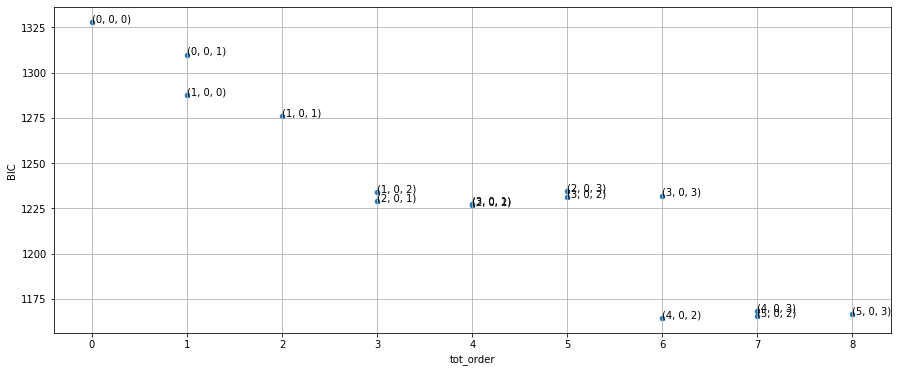

In [12]:
model_res = [(m.order, sum(m.order), m.bic()) for m in models]
model_res_df = pd.DataFrame(model_res, columns=['order', 'tot_order', 'BIC'])
util.scatter_with_labels(df=model_res_df, x='tot_order', y='BIC', val='order')

# Model Selection and Performance Plotting

In [13]:
ORDER_SELECED = (4,0,2)

selected_model = [m for m in models if m.order==ORDER_SELECED][0]
selected_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  240
Model:                     ARMA(4, 2)   Log Likelihood                -552.037
Method:                       css-mle   S.D. of innovations              2.391
Date:                Sun, 02 Feb 2020   AIC                           1126.073
Time:                        22:13:40   BIC                           1164.360
Sample:                             0   HQIC                          1141.500
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7115      1.270      4.498      0.000       3.223       8.200
x1             3.1752      0.109     29.134      0.000       2.962       3.389
x2            -5.0935      0.259    -19.642      0.000      -5.602      -4.585
x3             1.5991      0.258      6.198      0.000       1.093       2.105
ar.L1.y        1.1319      0.051     22.114      0.000       1.032       1.232
ar.L2.y       -0.4778      0.084     -5.662      0.000      -0.643      -0.312
ar.L3.y       -0.5182      0.083     -6.218      0.000      -0.682      -0.355
ar.L4.y        0.6417      0.050     12.713      0.000       0.543       0.741
ma.L1.y       -0.9170      0.032    -28.468      0.000      -0.980      -0.854
ma.L2.y        0.8879      0.042     21.029      0.000       0.805       0.971
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3489           -0.0000j            1.3489           -0.5000
AR.2            0.5043           -0.8673j            1.0032           -0.1662
AR.3            0.5043           +0.8673j            1.0032            0.1662
AR.4            1.1478           -0.0000j            1.1478           -0.0000
MA.1            0.5164           -0.9271j            1.0612           -0.1691
MA.2            0.5164           +0.9271j            1.0612            0.1691
-----------------------------------------------------------------------------
"""

In [14]:
params = util.name_params(selected_model)
params

const    5.711488
t        3.175216
sin     -5.093541
cos      1.599072
ar1      1.131906
ar2     -0.477813
ar3     -0.518187
ar4      0.641744
ma1     -0.916981
ma2      0.887939
dtype: float64

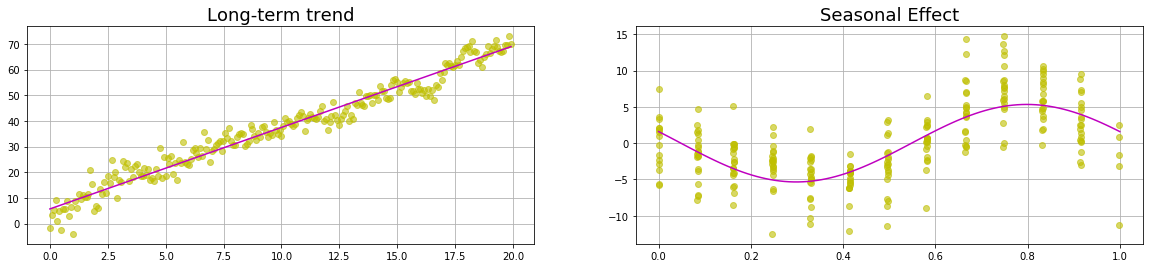

In [15]:
util.plot_trend_and_seasonal_effects(t, values, params);

# Prediction

In [25]:
new_t = util.timeindex_to_yearfraction(new_timeindex, t0=df.index[0])

new_exog = pd.DataFrame({
    't': new_t,
    'sin': np.sin(2*np.pi*new_t),
    'cos': np.cos(2*np.pi*new_t)
})

new_exog.head(3)

,t,sin,cos
0,20.000000,-4.898587e-15,1.000000
1,20.084873,5.083564e-01,0.861147
2,20.161533,8.494505e-01,0.527668


In [28]:
prediction = selected_model.predict(
    n_periods=new_exog.shape[0],
    exogenous=new_exog
)


# Checking

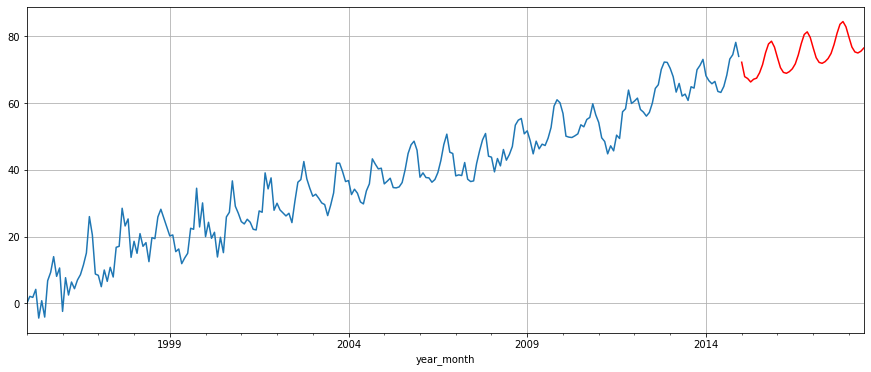

In [39]:
pred_df = pd.DataFrame({'sealevel': prediction}, index=new_timeindex)

ax = df.squeeze().plot()
pred_df.squeeze().plot(ax=ax, c='r')

# Exporting

In [50]:
export_df = pd.DataFrame({
    'year': pred_df.index.year,
    'month': pred_df.index.month,
    'sealevel': pred_df.sealevel.values,
})
export_df.to_csv('sealevel_predicted.csv', index=False, header=False)